In [1]:
import torch
from torch import nn

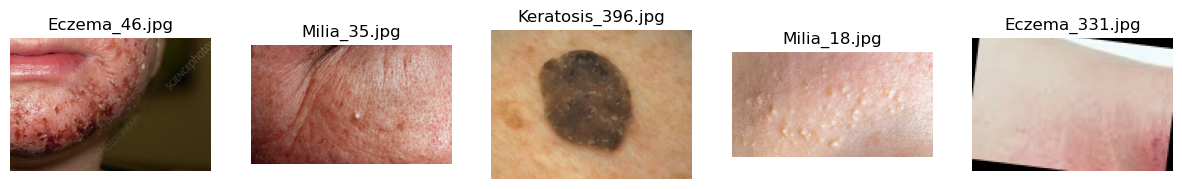

CPU times: total: 406 ms
Wall time: 871 ms


In [2]:
%%time
import os
import random
from matplotlib import pyplot as plt
from PIL import Image
import glob

# Path to the main directory containing subfolders with images
main_directory = 'Skin_Conditions'

# Use glob to find all .jpg files in subdirectories
image_paths = glob.glob(os.path.join(main_directory, '**', '*.jpg'), recursive=True)

# Select 5 random images image paths
random_images = random.sample(image_paths, 5)

# Display the selected images
plt.figure(figsize=(15, 10))

for i, image_path in enumerate(random_images):
    img = Image.open(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(image_path))

plt.show()

In [3]:
import os
import random
from PIL import Image
import torch
from torchvision import transforms

# Path to the main directory containing subfolders with images
main_directory = 'Skin_Conditions'

image_paths = []

# Loop through each subfolder and collect all image paths
for subdir, _, files in os.walk(main_directory):
    for file in files:
        if file.endswith(('.jpg', '.jpeg')):  
            image_paths.append(os.path.join(subdir, file))

# Select one random image from the collected image paths
random_image_path = random.choice(image_paths)

# Load the image using PIL
image = Image.open(random_image_path)

# Define the transform to convert the image to a tensor
transform = transforms.ToTensor()

# Apply the transform to the image
image_tensor = transform(image)

# Display the tensor
print(f"Tensor shape: {image_tensor.shape}")
print(f"Tensor for the image {random_image_path}:")
print(image_tensor)

Tensor shape: torch.Size([3, 557, 685])
Tensor for the image Skin_Conditions\Keratosis\Keratosis_67.jpg:
tensor([[[0.2157, 0.1725, 0.1922,  ..., 0.4510, 0.4078, 0.3961],
         [0.1882, 0.1922, 0.2275,  ..., 0.4627, 0.4078, 0.3961],
         [0.2275, 0.2471, 0.2706,  ..., 0.3569, 0.4039, 0.4471],
         ...,
         [0.3098, 0.3059, 0.3176,  ..., 0.9255, 0.8980, 0.8706],
         [0.2863, 0.3137, 0.3373,  ..., 0.8627, 0.8118, 0.7843],
         [0.2627, 0.3176, 0.3451,  ..., 0.7412, 0.7255, 0.7451]],

        [[0.1137, 0.0706, 0.0902,  ..., 0.3882, 0.3451, 0.3333],
         [0.0863, 0.0902, 0.1255,  ..., 0.3882, 0.3451, 0.3333],
         [0.1255, 0.1451, 0.1686,  ..., 0.2824, 0.3294, 0.3725],
         ...,
         [0.2392, 0.2353, 0.2510,  ..., 0.6235, 0.5882, 0.5608],
         [0.2157, 0.2471, 0.2706,  ..., 0.5529, 0.5020, 0.4745],
         [0.1922, 0.2471, 0.2784,  ..., 0.4314, 0.4157, 0.4275]],

        [[0.0549, 0.0118, 0.0314,  ..., 0.4000, 0.3569, 0.3451],
         [0.0275, 

In [4]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import glob
from sklearn.model_selection import train_test_split

class SkinConditionDataset(Dataset):
    def __init__(self, root_dir=None, image_paths=None, labels=None, transform=None):
        """
        Custom dataset class for loading skin condition images.

        Args:
            root_dir (string, optional): The main directory containing subdirectories with images of different skin conditions.
                                         If specified, image_paths and labels should be None.
                                         Each subdirectory represents a class label, e.g., 'Acne', 'Carcinoma', etc.
            image_paths (list, optional): List of file paths to the images. If specified, root_dir should be None.
            labels (list, optional): List of labels corresponding to each image. Must be provided if image_paths is provided.
            transform (callable, optional): A function/transform that takes in a PIL image and returns a transformed version.
                                           

        Attributes:
            root_dir (string): The directory containing all the images and subfolders.
            image_paths (list): List of all image file paths.
            labels (list): List of labels corresponding to each image file.
            label_to_index (dict): A dictionary mapping label names to numerical indices.
        """
        self.transform = transform
        self.root_dir = root_dir  

        if root_dir:
            self.image_paths = []
            self.labels = []

            # Collect all image paths and labels
            for label in os.listdir(root_dir):
                label_dir = os.path.join(root_dir, label)
                if os.path.isdir(label_dir):
                    for img_path in glob.glob(os.path.join(label_dir, '*.jpg')) + \
                                   glob.glob(os.path.join(label_dir, '*.jpeg')):
                        self.image_paths.append(img_path)
                        self.labels.append(label)

            # Create a label to index mapping
            self.label_to_index = {label: idx for idx, label in enumerate(sorted(set(self.labels)))}
            # Convert labels to indices
            self.labels = [self.label_to_index[label] for label in self.labels]

        elif image_paths is not None and labels is not None:
            self.image_paths = image_paths
            self.labels = labels

            # Assume labels are already encoded as numbers
            self.label_to_index = None

        else:
            raise ValueError("Either root_dir or image_paths and labels must be provided.")

    def __len__(self):
        """Returns the total number of samples (images) in the dataset."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Retrieves the image and its corresponding label at the specified index.

        Args:
            idx (int): Index of the image and label to retrieve.

        Returns:
            tuple: (image, label) where image is a transformed PIL image converted to a tensor (if transform is provided),
                   and label is the corresponding class label index as an integer.
        """
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()           
])

In [5]:
full_dataset = SkinConditionDataset(root_dir='Skin_Conditions', transform=transform)

In [6]:
#Split the dataset into training and test sets
train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
    full_dataset.image_paths, full_dataset.labels, test_size=0.2, random_state=42, stratify=full_dataset.labels
)

In [7]:
# Step 5: Create dataset instances for training and testing
train_dataset = SkinConditionDataset(image_paths=train_image_paths, labels=train_labels, transform=transform)
test_dataset = SkinConditionDataset(image_paths=test_image_paths, labels=test_labels, transform=transform)

In [8]:
BATCH_SIZE = 16
train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False)

In [9]:
images, labels = next(iter(train_dataloader))

print(f"Batch size: {images.size(0)}, Image shape: {images.size()[1:]} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {labels.shape}")
print(f"Labels: {labels}")

Batch size: 16, Image shape: torch.Size([3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([16])
Labels: tensor([1, 5, 2, 0, 2, 5, 3, 3, 3, 4, 3, 2, 3, 2, 2, 5])


In [10]:
import os

root_dir = 'Skin_Conditions'

# Collect all unique labels from subdirectory names
labels = [label for label in os.listdir(root_dir) 
          if os.path.isdir(os.path.join(root_dir, label))]

label_to_index = {label: idx for idx, label in enumerate(sorted(labels))}

print(label_to_index)

{'Acne': 0, 'Carcinoma': 1, 'Eczema': 2, 'Keratosis': 3, 'Milia': 4, 'Rosacea': 5}


In [11]:
num_classes = 6
learning_rate = 0.0001
batch_size = BATCH_SIZE
num_epochs = 25
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [12]:
device

device(type='cuda')

In [13]:
import torch
import torch.nn as nn
from torchsummary import summary

class CustomCNN(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=5, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=7, padding=1, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )
        
        self.flatten = nn.Flatten()
        
        self.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(25600 , num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        #print(f"Shape after conv1: {x.shape}")
        x = self.conv2(x)
        #print(f"Shape after conv2: {x.shape}")
        x = self.conv3(x)
        #print(f"Shape after conv3: {x.shape}")
        x = self.conv4(x)
        #print(f"Shape after conv4: {x.shape}")
        x = self.flatten(x)
        #print(f"Shape after flatten: {x.shape}")
        x = self.fc(x)
        #print(f"Shape final: {x.shape}")
        return x

# Define a function to test the model using a dummy input
def test_custom_cnn():
    # Instantiate the model and move it to the device (CPU or GPU)
    model = CustomCNN(num_classes=num_classes).to(device)

    # Create a dummy input tensor with the shape (batch_size, channels, height, width)
    dummy_input = torch.rand(1, 3, 224, 224).to(device) 

    output = model(dummy_input)

    print(f"Output shape: {output.shape}")
    print(f"Output tensor: {output}")

    # Print the summary of the model
    summary(model, input_size=(3, 224, 224), device=str(device))

test_custom_cnn()

Output shape: torch.Size([1, 6])
Output tensor: tensor([[-0.6523, -0.2097,  1.2625, -0.4193,  0.2580, -0.4747]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
         LeakyReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
       BatchNorm2d-6        [-1, 128, 112, 112]             256
         LeakyReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 128, 27, 27]         409,728
      BatchNorm2d-10          [-1, 128, 27, 27]             256
        LeakyReLU-11          [-1, 128, 27, 27]               0
    

In [14]:
from sklearn.metrics import precision_score, recall_score

In [15]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    
    model.train()

    train_loss, train_acc = 0.0, 0.0
    all_preds, all_labels = [], []

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device).float(), y.to(device).long()

        y_pred = model(X).float()
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(y_pred, 1)
        train_acc += (predicted ==y).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        #NumPy does not work directly with data stored on the GPU. 
        # PyTorch tensors can be located on either the CPU or GPU,
        #  but NumPy arrays only reside on the CPU. When a PyTorch tensor is on the GPU, 
        # you need to first move it to the CPU using .cpu() before converting it to a NumPy array.

    precision = precision_score(all_labels, all_preds, average = 'weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    train_loss /= len(dataloader)  # Average the loss over all batches
    train_acc /= len(dataloader.dataset)  # Average the accuracy over all examples

    return train_loss, train_acc, precision, recall

In [16]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module, 
              device: torch.device):
    
    model.eval()  

    test_loss, test_acc = 0.0, 0.0  
    all_preds, all_labels = [], [] 

    with torch.no_grad():  
        for batch, (X, y) in enumerate(dataloader):  
            X, y = X.to(device).float(), y.to(device).long()  

            y_pred = model(X).float()  
            loss = loss_fn(y_pred, y) 
            test_loss += loss.item()  

            _, predicted = torch.max(y_pred, 1)  
            test_acc += (predicted == y).sum().item()  
            
            # Store predictions and labels for precision/recall calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    test_loss /= len(dataloader)  # Average the loss over all batches
    test_acc /= len(dataloader.dataset)  # Average the accuracy over all examples

    return test_loss, test_acc, precision, recall

In [17]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer, 
          loss_fn: torch.nn.Module, 
          scheduler: torch.optim.lr_scheduler._LRScheduler, 
          epochs: int, 
          device: torch.device):
    
    results = {
        "train_loss": [],
        "train_acc": [],
        "train_precision": [],
        "train_recall": [],
        "test_loss": [],
        "test_acc": [],
        "test_precision": [],
        "test_recall": []
    }  # Dictionary to store training and testing results for each epoch

    for epoch in tqdm(range(epochs), desc="Epochs"):  # Loop through all epochs
        train_loss, train_acc, train_precision, train_recall = train_step(model,
                                                                          train_dataloader,
                                                                          loss_fn,
                                                                          optimizer,
                                                                          device)  # Train the model

        test_loss, test_acc, test_precision, test_recall = test_step(model,
                                                                     test_dataloader,
                                                                     loss_fn,
                                                                     device)  # Evaluate the model

        scheduler.step(test_loss)  # Update the learning rate based on the test loss

        # Append results for this epoch to the results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['train_precision'].append(train_precision)
        results['train_recall'].append(train_recall)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
        results['test_precision'].append(test_precision)
        results['test_recall'].append(test_recall)

        # Print epoch results to monitor the training process
        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, "
              f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")

    return results

: 

In [18]:
# Initialize the model, loss function, optimizer, and scheduler
model = CustomCNN(num_classes=6).to(device)
loss_fn = nn.CrossEntropyLoss()  
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience= 5)

# Train the model
results = train(model=model, 
                train_dataloader=train_dataloader, 
                test_dataloader=test_dataloader, 
                optimizer=optimizer, 
                loss_fn=loss_fn, 
                scheduler=scheduler, 
                epochs=num_epochs, 
                device=device)


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25 - Train Loss: 1.3062, Train Acc: 0.5159, Train Precision: 0.5171, Train Recall: 0.5159, Test Loss: 0.9671, Test Acc: 0.6409, Test Precision: 0.6534, Test Recall: 0.6409


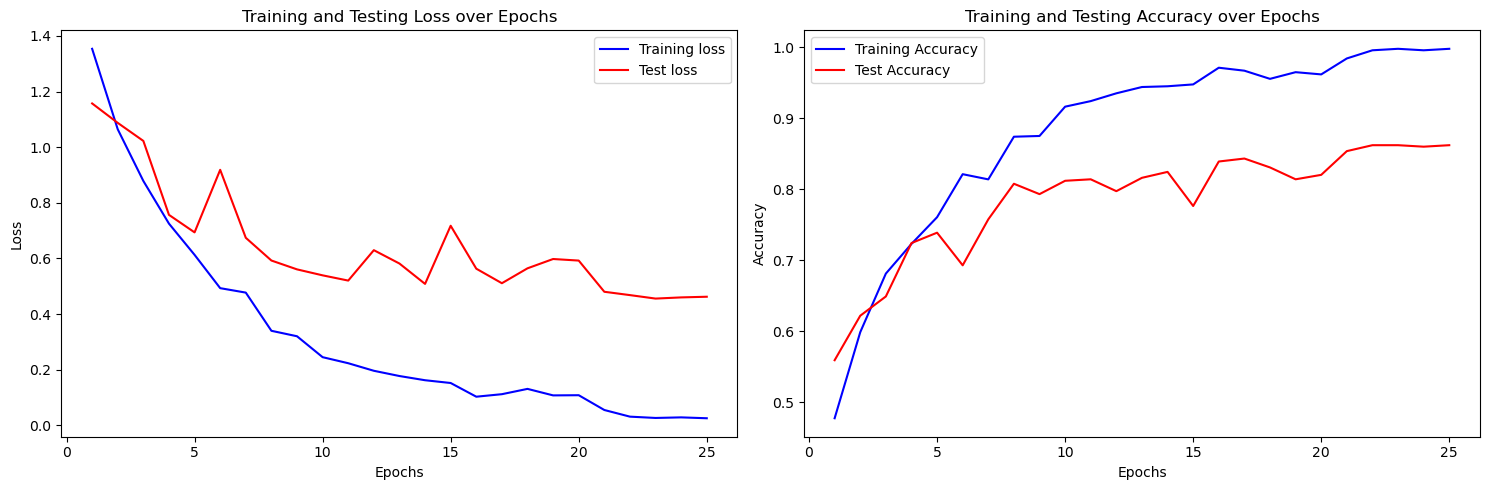

In [41]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(results):
    epochs = range(1, len(results['train_loss']) + 1)

    # Create a figure with two subplots: one for loss and one for accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # loss on first subplot
    ax1.plot(epochs, results['train_loss'], 'b', label='Training loss')
    ax1.plot(epochs, results['test_loss'], 'r', label='Test loss')
    ax1.set_title('Training and Testing Loss over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # accuracy on second subplot
    ax2.plot(epochs, results['train_acc'], 'b', label='Training Accuracy')
    ax2.plot(epochs, results['test_acc'], 'r', label='Test Accuracy')
    ax2.set_title('Training and Testing Accuracy over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_loss_and_accuracy(results)


In [53]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

y_preds = []
y_trues = []  
model.eval()  # Ensure model is in evaluation mode

with torch.inference_mode():  
    for X, y in tqdm(test_dataloader, desc='feeling good...'):
        # Send data to the target device
        X, y = X.to(device), y.to(device)
        
        y_logit = model(X)
        
        # Turn logits into prediction probabilities and then into prediction labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        
        y_preds.append(y_pred.cpu())
        y_trues.append(y.cpu())  # Append true labels

y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(y_trues)


feeling good...:   0%|          | 0/30 [00:00<?, ?it/s]

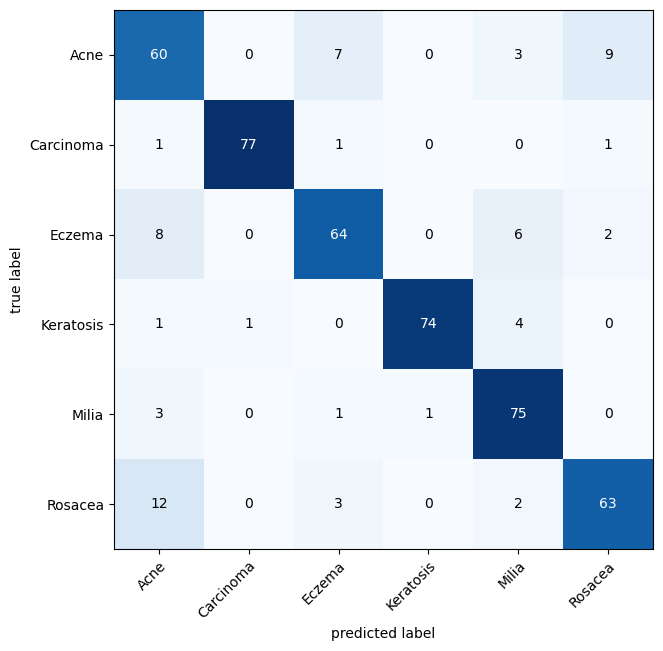

In [54]:
class_names = ['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']

num_classes = len(class_names) 

confmat = ConfusionMatrix(task='multiclass', num_classes=num_classes)
confmat_tensor = confmat(y_pred_tensor, y_true_tensor)

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), 
                                class_names=class_names, 
                                figsize=(10, 7))

plt.show()

Class names inferred: ['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']


feelin good...:   0%|          | 0/30 [00:00<?, ?it/s]

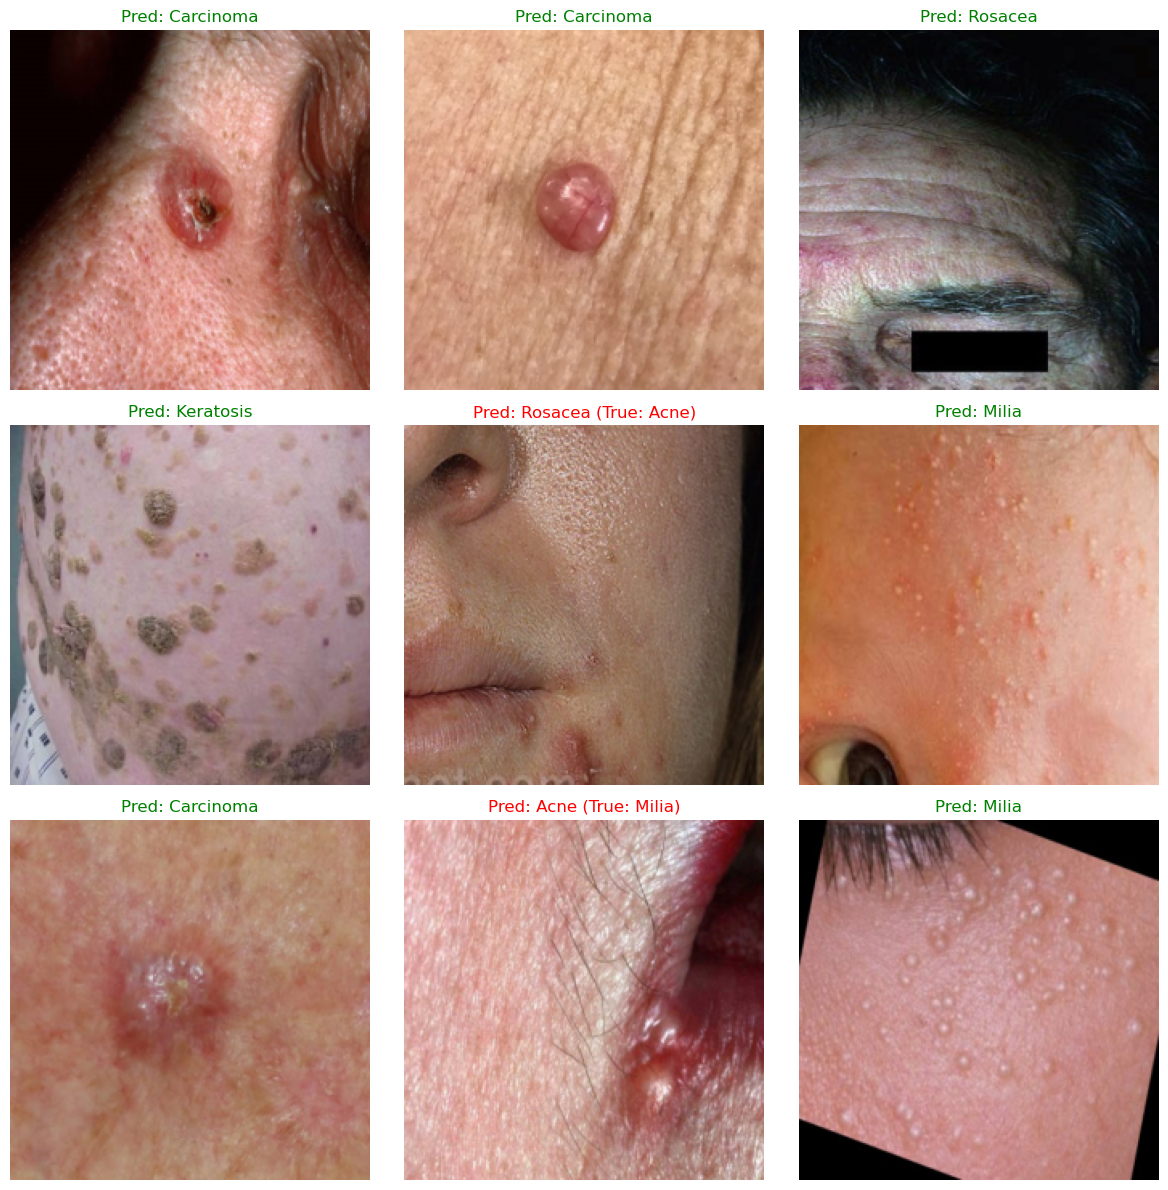

In [66]:
from tqdm.auto import tqdm

# Infer class names from the directory structure
labels = [label for label in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, label))]
label_to_index = {label: idx for idx, label in enumerate(sorted(labels))}

# Extract class names from the dictionary
class_names = list(label_to_index.keys())  

print(f"Class names inferred: {class_names}") 

y_preds = []
y_trues = []
model.eval()  # Ensure model is in evaluation mode

with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc='feelin good...'):

        X, y = X.to(device), y.to(device)
        
        y_logit = model(X)
        
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        
        y_preds.append(y_pred.cpu())
        y_trues.append(y.cpu())

y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(y_trues)

# Pick 9 random indices for displaying in a 3x3 grid
num_images = len(y_pred_tensor)
random_indices = np.random.choice(num_images, 9, replace=False)

fig, axs = plt.subplots(3, 3, figsize=(12, 12))  
axs = axs.flatten()  # Flatten the axes for easy iteration

# Plot each randomly chosen image
for i, idx in enumerate(random_indices):
    img = images[idx].permute(1, 2, 0).numpy()  # Convert from CHW to HWC
    true_label = y_true_tensor[idx].item()
    pred_label = y_pred_tensor[idx].item()

    axs[i].imshow(np.clip(img, 0, 1)) 
    axs[i].axis('off')

    # Set the title based on whether the prediction is correct or not
    if true_label == pred_label:
        axs[i].set_title(f"Pred: {class_names[pred_label]}", color='green', fontsize=12)
    else:
        axs[i].set_title(f"Pred: {class_names[pred_label]} (True: {class_names[true_label]})", color='red', fontsize=12)

plt.tight_layout()
plt.show()